# 使用字符级的RNN生成姓名

## Preparing the Data

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # 加上 EOS 标记

findFiles = lambda path : glob.glob(path)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def readLines(filename):
    lines = open(filename,encoding='utf-8').read().strip().split('\n')
    return [ unicodeToAscii(line) for line in lines] 

category_lines = {}
all_categories = []

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Japanese', 'Spanish', 'Arabic', 'Italian', 'Irish', 'German', 'Dutch', 'Russian', 'Vietnamese', 'English', 'Polish', 'Czech', 'Scottish', 'Korean', 'Portuguese', 'Chinese', 'Greek', 'French']
O'Neal


## Creating the Network

In [2]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(n_categories + input_size + hidden_size,hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, category, input, hidden):
        input_combined = torch.cat((category,input,hidden),1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)



## Training the Data

### Preparing for Training

In [3]:
import random

def randomChoice(l):
    """
    从列表中随机获取一个对象
    :param l: 
    :return: 
    """
    return l[random.randint(0,len(l)-1)]

def randomTrainingPair():
    """
    获取随机的一对 (category, line)
    :return: 
    """
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

对于训练单词的每一字母，网络的输入都是 (category, current_letter, hidden_state)
输出都是(next_letter, next_hidden_state)

因为

In [4]:
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1,n_categories)
    tensor[0][li] = 1
    return tensor

def inputTensor(line):
    tensor = torch.zeros(len(line),1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

## Training the Network

In [5]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

rnn = RNN(n_letters, 128, n_letters)

def train(category_tensor,input_line_tensor,target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    loss = 0
    
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor,input_line_tensor[i],hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l
    
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(-learning_rate,p.grad.data)
    
    return output, loss.item()/input_line_tensor.size(0)

In [6]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

    

In [7]:
n_epochs = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for epoch in range(1, n_epochs+1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss
    
    
    if epoch % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), epoch, epoch / n_epochs * 100, loss))

    if epoch % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 19s (5000 5%) 2.5394
0m 44s (10000 10%) 3.3092
1m 12s (15000 15%) 2.4766
1m 31s (20000 20%) 2.7845
1m 49s (25000 25%) 3.2564
2m 9s (30000 30%) 1.8879
2m 27s (35000 35%) 3.0612
2m 46s (40000 40%) 1.8675
3m 5s (45000 45%) 2.7014
3m 25s (50000 50%) 3.2187
3m 44s (55000 55%) 2.2190
4m 1s (60000 60%) 1.8567
4m 30s (65000 65%) 3.1273
4m 51s (70000 70%) 2.0443
5m 10s (75000 75%) 2.5308
5m 28s (80000 80%) 2.2911
5m 57s (85000 85%) 1.6073
6m 25s (90000 90%) 2.5208
6m 43s (95000 95%) 2.5006
7m 1s (100000 100%) 2.0711


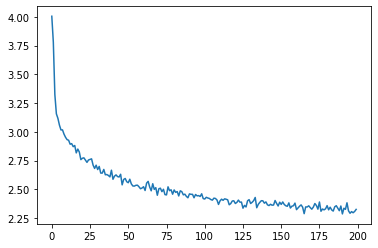

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Sampling the Network

In [9]:
max_length = 20
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')



Roski
Uakin
Shinikov
Ganter
Eren
Roure
Santan
Panel
Alane
Chan
Han
Iun
